# Modular CerberusTS Experimentation

First we make sure we are in the base working directory (this is probably not necessary if using the package):

Google Colab notebooks come with most of the packages we need, but we need to upgrade pandas and install accelerate.

Then we import the necessary CerberusTS modules.

In [1]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    # Print the number of available CUDA devices
    print(f"Number of CUDA devices available: {torch.cuda.device_count()}")

    # Print each CUDA device
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

Number of CUDA devices available: 1
CUDA Device 0: NVIDIA GeForce GTX 1650 with Max-Q Design


In [2]:
from cerberus_ts import CerberusConfig
CerberusConfig.set_masked_norm_zero = True
CerberusConfig.processor_type = 'flatten'
CerberusConfig.foresight_residual = False

c:\Users\johnm\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import Foresight, train_foresight
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator

import pandas as pd

Here we have the ability to do some custom configuration:

## Dataset Loading

Next we need a Pandas Dataframe of some wide-formatted mutlivariate timeseries data. Here we will use the Jena Climate Data found here: https://www.kaggle.com/datasets/mnassrib/jena-climate

In [4]:
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:5000,:]

## User Argument Specification
There are a number of different arguments that can be provided to Cerberus, shown below:

In [5]:
# What ratio of data needs to be available for the various call, response, and context windows to use that timestamp?
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

# How big should the call, context(s), and response windows be?
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

# What timestep should each head use?
window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

# Which columns should be used for each head?
feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)
}

## Prepare Dataset

We will use CerberusTS's TimeseriesDataPreparer class to create Torch dataloaders for all our different heads, scaled, downsampled, and coil-normalized for easy Cerberus use.

In [6]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 100)

# Prepare the data
preparer.prepare_data()

In [7]:
iterator = iter(preparer.dataloaders)
batch = next(iterator)
batch[0].device

device(type='cuda', index=0)

## Foresight Training

First, we can optionally train Foresight to aid CerberusTS:

In [8]:
foresight = Foresight(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [1024, 512],
                 dropout_rate = 0.0,
                 eventualities = 10,
                 expander_sizes = [512, 1024],
                 out_channels = 128,
                 last_known_loc = 2)

In [9]:
foresight = train_foresight(foresight, preparer.dataloaders, num_epochs = 100)

Epoch [1/100], Loss: 0.006460582081926986
Epoch [2/100], Loss: 0.002538629121845588
Epoch [3/100], Loss: 0.0020931227057008075
Epoch [4/100], Loss: 0.001726570773171261
Epoch [5/100], Loss: 0.0014414129621582105
Epoch [6/100], Loss: 0.00110251006874023
Epoch [7/100], Loss: 0.0008508905462804251
Epoch [8/100], Loss: 0.0005958285377710127
Epoch [9/100], Loss: 0.0004300479836820159
Epoch [10/100], Loss: 0.0003427113669749815
Epoch [11/100], Loss: 0.00021335701967473142
Epoch [12/100], Loss: 0.00013514517351723043
Epoch [13/100], Loss: 9.254495769710047e-05
Epoch [14/100], Loss: 6.679135491140187e-05
Epoch [15/100], Loss: 4.1818900672296874e-05
Epoch [16/100], Loss: 3.066074193156965e-05
Epoch [17/100], Loss: 4.166742329289263e-05
Epoch [18/100], Loss: 3.469131851488783e-05
Epoch [19/100], Loss: 4.101962214008381e-05
Epoch [20/100], Loss: 3.598536003664776e-05
Epoch [21/100], Loss: 0.00019155607114953454
Epoch [22/100], Loss: 0.000676822312962031
Epoch [23/100], Loss: 0.0001457443002982472

## CerberusTS Training (No Foresight)

In [10]:
cerberus_noforesight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128  ,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [2048, 1024, 512, 256],
                 dropout_rate = 0.0,
                 out_channels = 128,
                 last_known_loc= 2 )
                 

In [11]:
cerberus_noforesight = train_cerberus(cerberus_noforesight, preparer.dataloaders, num_epochs = 100)

Epoch [1/100], Loss: 0.0004304387040610891
Epoch [2/100], Loss: 0.00035255134709586853
Epoch [3/100], Loss: 0.0003253120904264506
Epoch [4/100], Loss: 0.00030712741492607167
Epoch [5/100], Loss: 0.00028971947627724146
Epoch [6/100], Loss: 0.0002734104314731667
Epoch [7/100], Loss: 0.00025746766186784953
Epoch [8/100], Loss: 0.00024108179633913095
Epoch [9/100], Loss: 0.00023075118238921277
Epoch [10/100], Loss: 0.00021990834095049648
Epoch [11/100], Loss: 0.00020439610801986418
Epoch [12/100], Loss: 0.00019070724069024435
Epoch [13/100], Loss: 0.00018327688245335595
Epoch [14/100], Loss: 0.00016874843477125977
Epoch [15/100], Loss: 0.00015894678843324074
Epoch [16/100], Loss: 0.0001511292304348899
Epoch [17/100], Loss: 0.0001440015618572943
Epoch [18/100], Loss: 0.00013627982487378177
Epoch [19/100], Loss: 0.00012381487016682513
Epoch [20/100], Loss: 0.00011522547341883183
Epoch [21/100], Loss: 0.00011509343807119876
Epoch [22/100], Loss: 0.0001121444879390765
Epoch [23/100], Loss: 9.8

## CerberusTS Training (With Foresight)
With the Foresight model trained (and weights frozen), we can pass this into a Cerberus model and train the remaining weights to generate predictions.

In [12]:
cerberus_foresight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [2048, 1024, 512, 256],
                 dropout_rate = 0.0,
                 foresight = foresight,
                 eventualities = 10,
                 out_channels = 128,
                 last_known_loc = 2)

In [13]:
cerberus_foresight = train_cerberus(cerberus_foresight, preparer.dataloaders, num_epochs = 100)

Epoch [1/100], Loss: 0.000362626737478422
Epoch [2/100], Loss: 0.00024921963609813246
Epoch [3/100], Loss: 0.0001901962888223352
Epoch [4/100], Loss: 0.00014973530313000083
Epoch [5/100], Loss: 0.00011974303295573918
Epoch [6/100], Loss: 0.00010416526085464283
Epoch [7/100], Loss: 9.0166112913721e-05
Epoch [8/100], Loss: 7.623079456607229e-05
Epoch [9/100], Loss: 6.613859726712689e-05
Epoch [10/100], Loss: 5.7932401014113565e-05
Epoch [11/100], Loss: 5.018652498620213e-05
Epoch [12/100], Loss: 4.4733954728144456e-05
Epoch [13/100], Loss: 3.895532268870738e-05
Epoch [14/100], Loss: 3.1080880771696686e-05
Epoch [15/100], Loss: 3.0436112474490074e-05
Epoch [16/100], Loss: 2.6328579770051876e-05
Epoch [17/100], Loss: 2.4248959116448533e-05
Epoch [18/100], Loss: 2.1136490358912853e-05
Epoch [19/100], Loss: 1.9288895023237272e-05
Epoch [20/100], Loss: 1.992308411445265e-05
Epoch [21/100], Loss: 1.719233241601614e-05
Epoch [22/100], Loss: 1.5981226351868826e-05
Epoch [23/100], Loss: 1.7767980

## Results Review

CerberusTS has some built in functionality for generating responses as well as visualizing the results.

### Normalized Response Review

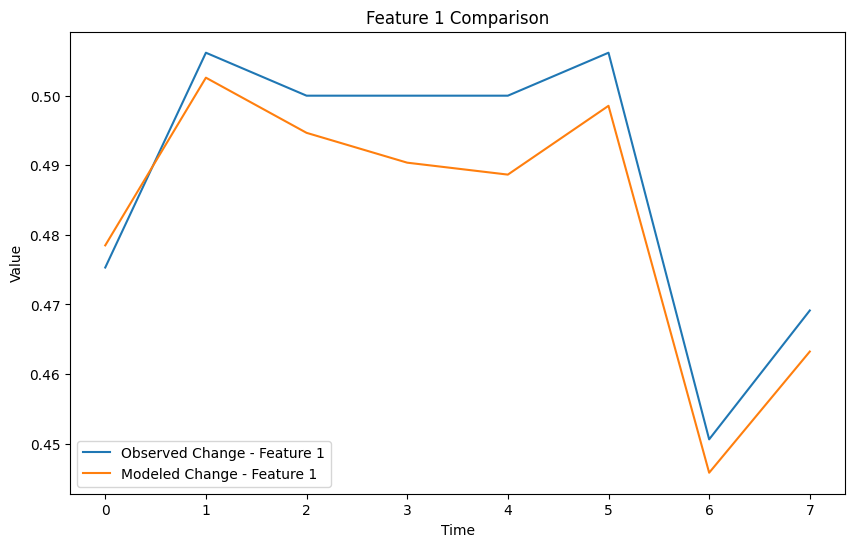

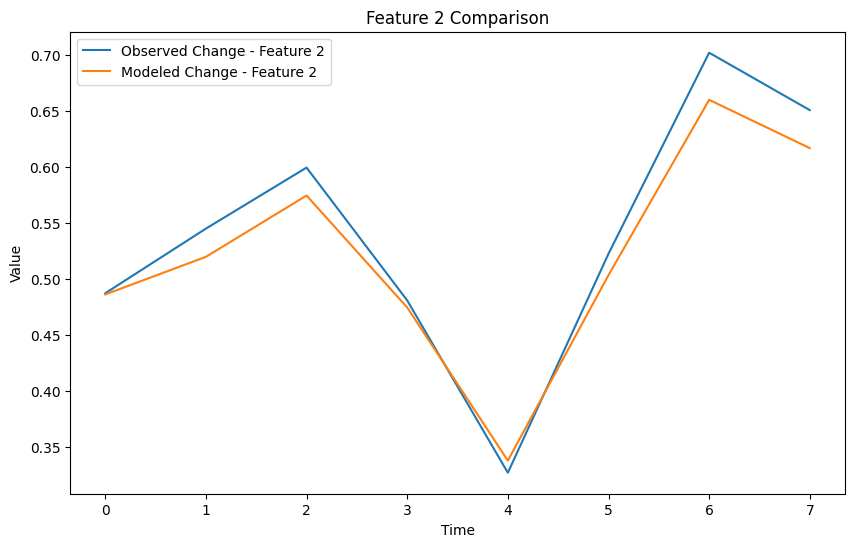

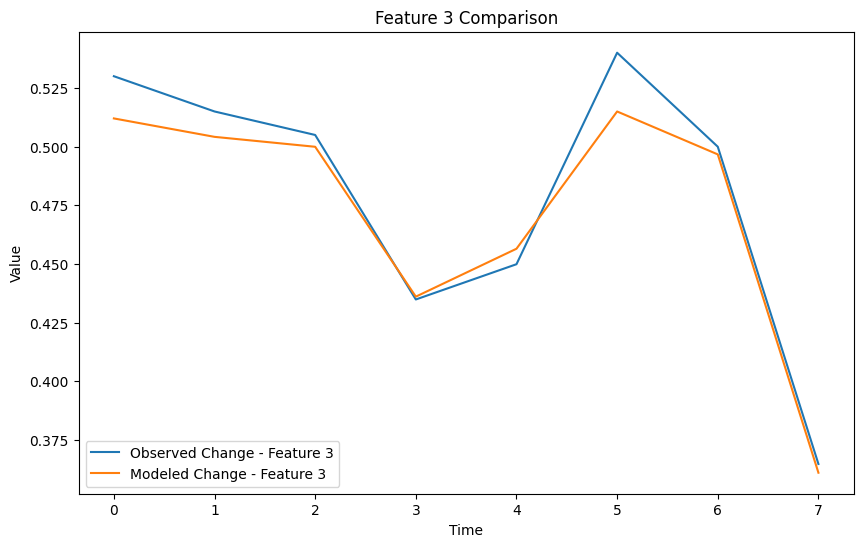

In [31]:
# Intialize Response Generator
generator = ResponseGenerator(cerberus_foresight, preparer.sliced_data, feature_indexes, preparer.max_change_dfs)

# Generate a response for a specific index
sel_index = 123
generator.generate_response(sel_index)

generator.plot_normalized_responses()

### Unscaled Response Review

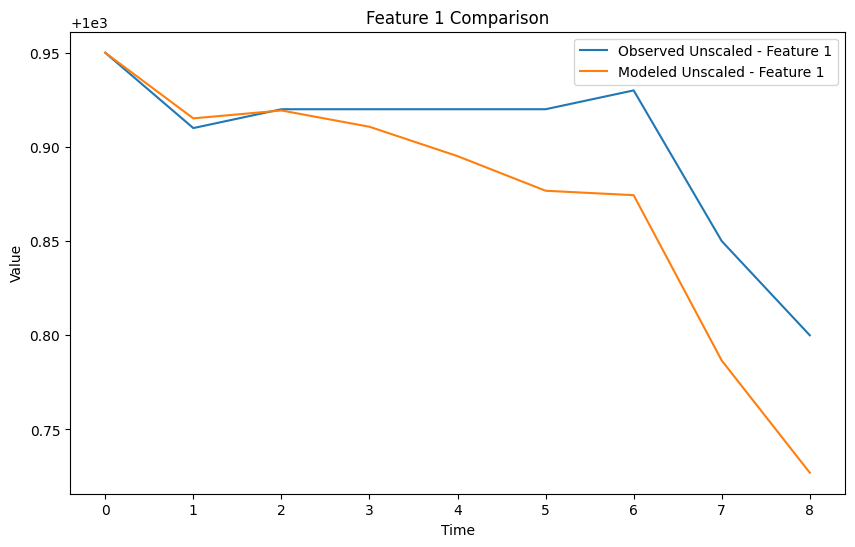

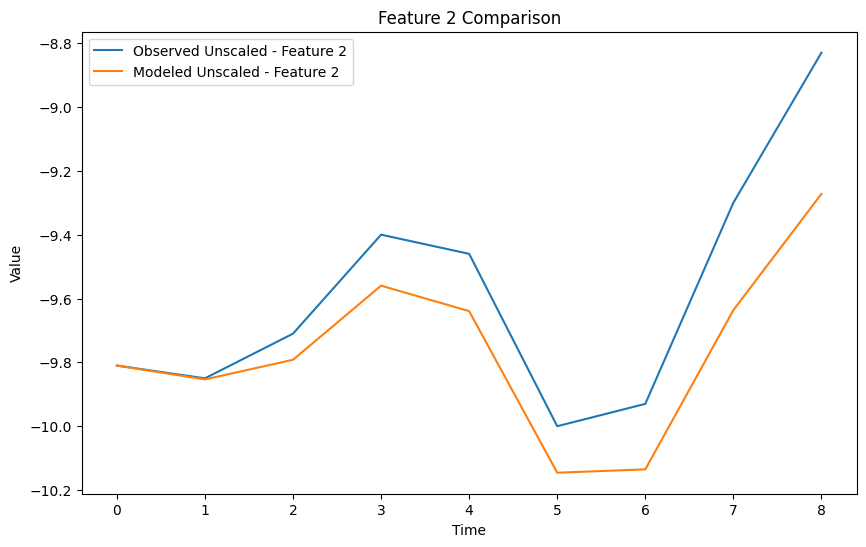

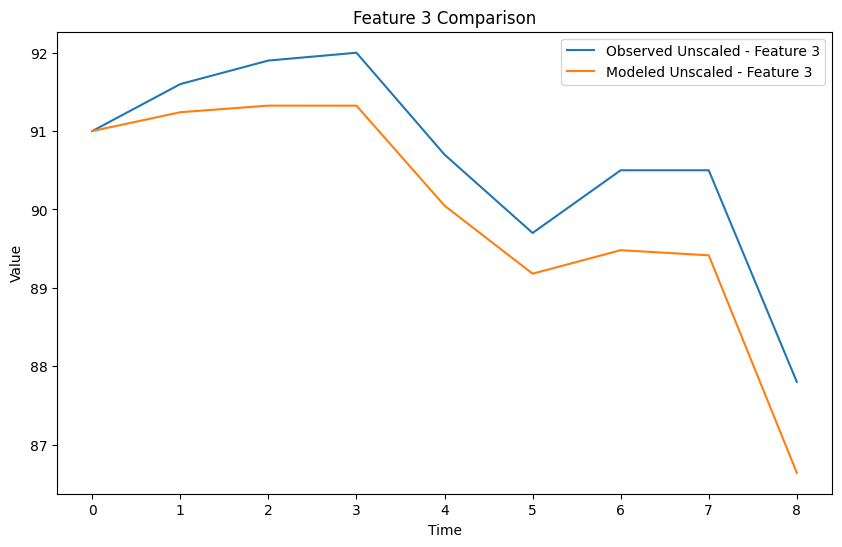

In [22]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)

In [16]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(cerberus_foresight)

18052355